In [1]:
import numpy as np
from scipy.spatial.distance import pdist
from scipy.integrate import odeint
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LinearRegression

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#introduction" data-toc-modified-id="introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>introduction</a></span></li><li><span><a href="#Solving-the-Lorenz-System" data-toc-modified-id="Solving-the-Lorenz-System-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Solving the Lorenz System</a></span></li><li><span><a href="#Calculating-the-correlation-dimension" data-toc-modified-id="Calculating-the-correlation-dimension-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Calculating the correlation dimension</a></span></li><li><span><a href="#Reconstructing-phase-space" data-toc-modified-id="Reconstructing-phase-space-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Reconstructing phase space</a></span><ul class="toc-item"><li><span><a href="#Calculating-the-correlation-dimension-of-the-reconstructed-phase-space" data-toc-modified-id="Calculating-the-correlation-dimension-of-the-reconstructed-phase-space-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Calculating the correlation dimension of the reconstructed phase space</a></span></li></ul></li></ul></div>

# introduction

The aim on this notebook is to test the tools of chaos theory. To validate my implementation I test the metrics on the Lorenz attractor, for which the wished results are known. The results presented here are based on _Nonlinear Dynamics and Chaos_ by Steven H. Strogatz as well as the paper _Estimating the Fractal Dimension of Chaotic Time Series_ by J. Theiler  (The Lincoln Laboratory Journal, Volume 3, Number 1, 1990).

# Solving the Lorenz System
The Lorenz system is a one of the most often cited systems that exhibit Chaos, probably because of its importance in the development of the field. Below I define the dynamical system and solve it. The solution will be the data on which I calculate the metrics.

In [2]:
def lorenz_deriv(x_y_z, t0, sigma=10, beta=8./3, rho=28.0):
        """Compute the time-derivative of a Lorenz system."""
        x, y, z = x_y_z
        return [sigma * (y - x), x * (rho - z) - y, x * y - beta * z]
    
def solve_lorenz(max_time=4.0, sigma=10.0, beta=8./3, rho=28.0):
    # Choose random starting points, uniformly distributed from -15 to 15
    np.random.seed(1)
    x0 = -15 + 30 * np.random.random((3,))
    
    # Solve for the trajectories
    t = np.linspace(0, max_time, int(250*max_time))
    x_t = odeint(lorenz_deriv, x0, t)
    return t, x_t

In [3]:
t, x_t = solve_lorenz(max_time=150)

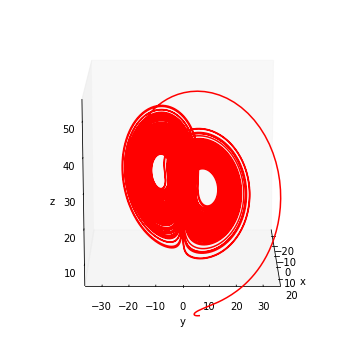

In [4]:
fig, ax = plt.subplots(figsize=(6,6), subplot_kw={'projection':'3d'})
ax.set_xlim((-25, 25))
ax.set_ylim((-35, 35))
ax.set_zlim((5, 55))

x, y, z = x_t.T
ax.plot(x, y, z, '-r')
ax.grid(False)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(15, 0)

fig.patch.set_facecolor('none')
fig.patch.set_alpha(0.0)

fig.savefig('lorenz-trajectory.png', transparent=True)

Saving the trajectory.

In [5]:
np.savetxt('lorenz-trajectory.csv',
           x_t[:10000, :],
           delimiter=',',
           fmt='%10.10f',
           header='x,y,z')

# Calculating the correlation dimension
The definition of correlation dimension is taken from p. 412 _Nonlinear Dynamics and Chaos_ by Steven H. Strogatz.

In [6]:
def C(vec, epsilon):
    dist = pdist(vec)
    cnt = np.sum(dist<epsilon)
    return (1/np.square(vec.shape[1]))*cnt

In [7]:
epsilons = np.logspace(-1.5, 1, 20)
Cs = []
for epsilon in epsilons:
    c = C(x_t, epsilon)
    Cs.append(c)

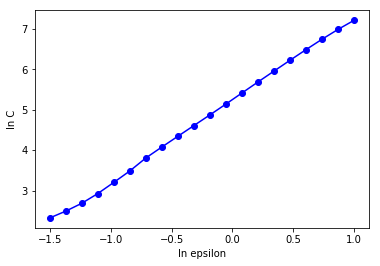

In [8]:
fig, ax = plt.subplots()
ax.plot(np.log10(epsilons), np.log10(np.array(Cs)), 'o-b');
ax.set_xlabel('ln epsilon')
ax.set_ylabel('ln C');
fig.savefig('correlation-dimension.png', transparent=True)

In [9]:
model = LinearRegression()
X = np.log10(epsilons.reshape(-1,1))
Y = np.log10(np.array(Cs).reshape(-1,1))
model.fit(X, Y)

/Users/hartmann/Documents/projects/reproduced-papers/lorentz-attractor/env/lib/python3.6/site-packages/sklearn/linear_model/base.py:509: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [10]:
model.coef_[0][0]

2.023678458041707

The result should be close to 2.05.

# Reconstructing phase space
The idea behind reconstructing a phase space is that some of the information is encapsulated in the each dimension of the dynamical system. In fact, it turns out that it is possible to get a glimpse of the strange attractor by simply plotting one of the variables against time-lagged versions of itself. This is called embedding. Below I use for different lag times to reconstruct the Lorenz attractor using just the x-dimension of the trajectory used above.

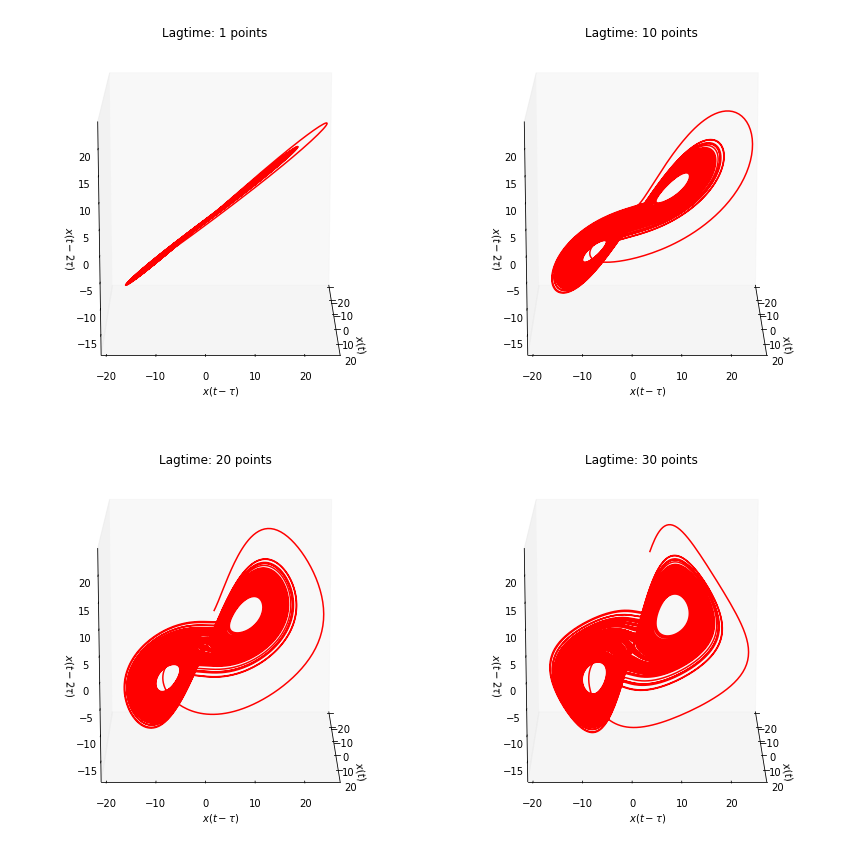

In [11]:
lagtimes = [1, 10, 20, 30]

fig, axes = plt.subplots(ncols=2, nrows=2,
                         figsize=(12,12),
                         subplot_kw={'projection':'3d'})

for ax, lagtime in zip(axes.flat, lagtimes):
    ax.plot(x[:-2*lagtime], x[lagtime:-lagtime], x[2*lagtime:], '-r')
    ax.grid(False)
    ax.set_xlabel(r'$x(t)$')
    ax.set_ylabel(r'$x(t-\tau)$')
    ax.set_zlabel(r'$x(t-2\tau)$')
    ax.view_init(15, 0)
    ax.set_title('Lagtime: {0} points'.format(lagtime) )
fig.tight_layout()
fig.savefig('phase-space-reconstruction.png', transparent=True)

## Calculating the correlation dimension of the reconstructed phase space

In [12]:
x_reconstructed = np.vstack([x[:-2*lagtime], x[lagtime:-lagtime], x[2*lagtime:]]).transpose()

In [13]:
epsilons = np.logspace(-1.5, 1, 20)
Cs = []
for epsilon in epsilons:
    c = C(x_reconstructed, epsilon)
    Cs.append(c)

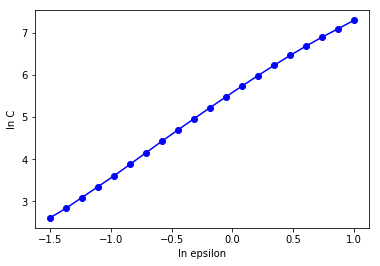

In [14]:
fig, ax = plt.subplots()
ax.plot(np.log10(epsilons), np.log10(np.array(Cs)), 'o-b');
ax.set_xlabel('ln epsilon')
ax.set_ylabel('ln C');
fig.savefig('phase-space-reconstruction-correlation-dimension.png', transparent=True)

In [15]:
model = LinearRegression()
X = np.log10(epsilons.reshape(-1,1))
Y = np.log10(np.array(Cs).reshape(-1,1))
model.fit(X, Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [16]:
model.coef_[0][0]

1.9205179764911522